## Problem: 

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

#### Source: 
https://www.kaggle.com/c/tgs-salt-identification-challenge


### Note: 
Accept the terms and download data from the above link

### Aim: 

Implement U-Net neural model architecture in keras to solve this problem.


In this, you are asked to segment salt deposits beneath the Earth’s surface. Given a set of seismic images that are 101 x 101 pixels each and each pixel we need to classify as either salt or sediment. Our goal is to segment regions that contain salt. A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. 

### Steps:

1. Download the dataset
2. Upload to Drive
3. Import from drive to colab
4. Load the images
5. Build U-net Model
6. Train
7. Report train and test accuracy

In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
project_path = '/content/drive/My Drive/AIML/Lab/AdvancedCV/Internal/'

In [0]:
#set parameters

im_width = 128
im_height = 128
border = 5
path_train = project_path + 'train/'
path_test = project_path + 'test/'

In [4]:
!mkdir train
!mkdir test

mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘test’: File exists


In [0]:
from zipfile import ZipFile

with ZipFile(project_path + 'train.zip', 'r') as zf:
  zf.extractall('train/')  

In [0]:
with ZipFile(project_path + 'test.zip', 'r') as zf:
  zf.extractall('test/')

In [7]:
#resize images
import os
import numpy as np
from tqdm import tqdm_notebook, tnrange
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

def get_data(path, train=True):
  ids = next(os.walk("train/images"))[2]
  X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
  if train:
    y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
  print('Resizing image')
  
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    img = load_img('train/images/' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    if train:
      mask = img_to_array(load_img('train/masks/' + id_, grayscale=True))
      mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)
      
    X[n, ..., 0] = x_img.squeeze()/255
    
    if train:
      y[n] = mask/255
  
  print('Done')
  
  if train:
    return X, y
  else:
    return X
  
X, y = get_data(path_train, train=True)

Using TensorFlow backend.


Resizing image


/usr/local/lib/python2.7/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



Done


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=100)

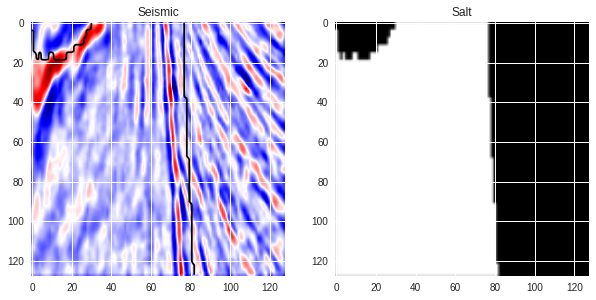

In [9]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

#Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10,10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

In [0]:
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import Model, load_model
import tensorflow as tf

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:
def get_unet(input_img, n_filters=1, dropout=0.5, batchnorm=True):
  
  #Contraction
  c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
  p1 = MaxPooling2D(pool_size=(2,2)) (c1)
  p1 = Dropout(dropout)(p1)
  
  c2 = conv2d_block(p1, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
  p2 = MaxPooling2D(pool_size=(2,2)) (c2)
  p2 = Dropout(dropout)(p2)
  
  c3 = conv2d_block(p2, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
  p3 = MaxPooling2D(pool_size=(2,2)) (c3)
  p3 = Dropout(dropout)(p3)
  
  c4 = conv2d_block(p3, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
  p4 = MaxPooling2D(pool_size=(2,2)) (c4)
  p4 = Dropout(dropout)(p4)
  
  c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
  
  # expansion
  u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  u6 = Dropout(dropout)(u6)
  c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

  u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  u7 = Dropout(dropout)(u7)
  c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

  u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  u8 = Dropout(dropout)(u8)
  c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

  u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  u9 = Dropout(dropout)(u9)
  c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
  model = Model(inputs=[input_img], outputs=[outputs])
  return model  

In [12]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activat

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(project_path + 'model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [14]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Instructions for updating:
Use tf.cast instead.
Train on 2800 samples, validate on 1200 samples
Epoch 1/100
2800/2800 [==============================] - 29s 11ms/step - loss: 0.5133 - acc: 0.7574 - val_loss: 0.5575 - val_acc: 0.7894

Epoch 00001: val_loss improved from inf to 0.55754, saving model to /content/drive/My Drive/AIML/Lab/AdvancedCV/Internal/model-tgs-salt.h5
Epoch 2/100
2800/2800 [==============================] - 24s 8ms/step - loss: 0.3458 - acc: 0.8691 - val_loss: 0.6094 - val_acc: 0.8452

Epoch 00002: val_loss did not improve from 0.55754
Epoch 3/100
2800/2800 [==============================] - 24s 8ms/step - loss: 0.3045 - acc: 0.8795 - val_loss: 0.3242 - val_acc: 0.8600

Epoch 00003: val_loss improved from 0.55754 to 0.32416, saving model to /content/drive/My Drive/AIML/Lab/AdvancedCV/Internal/model-tgs-salt.h5
Epoch 4/100
2800/2800 [==============================] - 23s 8ms/step - loss: 0.2745 - acc: 0.8900 - val_loss: 0.2995 - val_acc: 0.8754

Epoch 00004: val_loss 

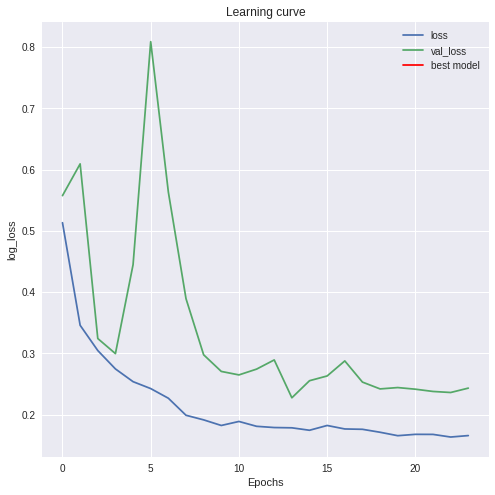

In [15]:
#Checking how the model progressed pictorically & also identify the best model

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [0]:
# Load best model
model.load_weights(project_path + 'model-tgs-salt.h5')

In [17]:
# Evaluate on validation set, this would be the best model outcome

model.evaluate(X_valid, y_valid, verbose=1)

1200/1200 [==============================] - 2s 2ms/step


[0.22735860685507456, 0.899359130859375]

In [18]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

1200/1200 [==============================] - 2s 2ms/step


In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

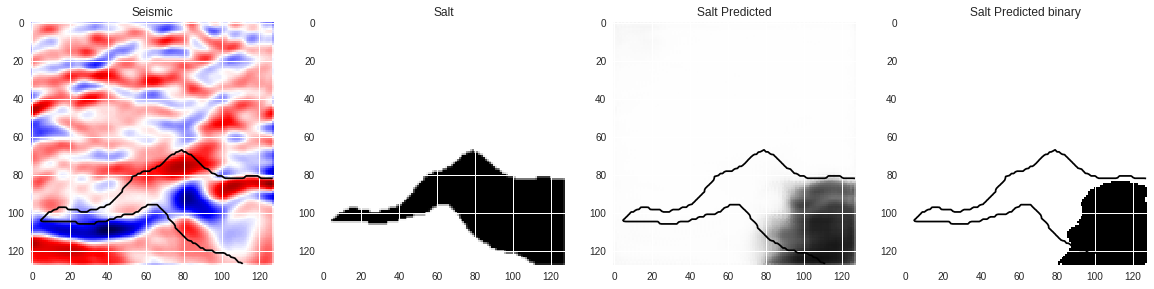

In [20]:
# Check if training data looks all right

plot_sample(X_train, y_train, preds_train, preds_train_t, ix=15)

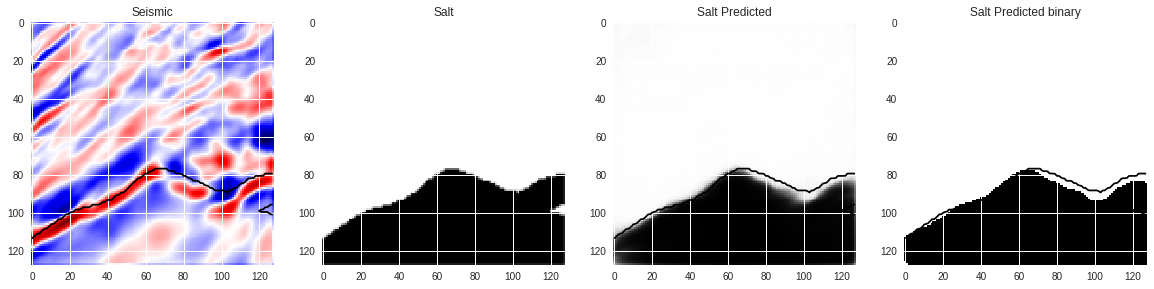

In [21]:
# Check if valid data looks all right

plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=14)